In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import os
from tqdm import tqdm

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
PATH = Path('../data/')

In [5]:
! ls {PATH}

download.sh  models  train-jpg	train_v2.csv


In [6]:
np.random.seed(96)

In [7]:
size=224
bs=64
src = (ImageItemList.from_csv(PATH, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms, size=size)
        .databunch().normalize(imagenet_stats))

In [8]:
arch = models.resnet50

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [20]:
learn.model


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [21]:
from torchsummary import summary
summary(learn.model, (3, size, size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


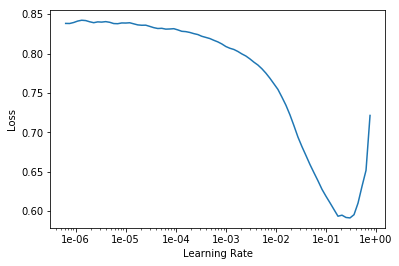

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(4, max_lr=0.01)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.122908,0.114703,0.946794,0.893566
2,0.111613,0.094335,0.952367,0.916494
3,0.098738,0.086926,0.955557,0.923642
4,0.093354,0.083181,0.957541,0.926336


In [25]:
learn.save('stage-1')

Initial train is done. Let's see some of the worst preditions.

In [17]:
learn.load('stage-1');

In [18]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


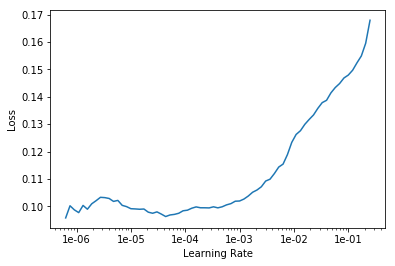

In [19]:
learn.recorder.plot()

In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.097429,0.086158,0.956582,0.922425
2,0.095763,0.085443,0.956974,0.923276


In [22]:
learn.save('stage-2');

Train with bigger images.

In [26]:
data = (src.transform(tfms, size=334)
        .databunch(bs=32).normalize(imagenet_stats))

learn.data = data

In [27]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


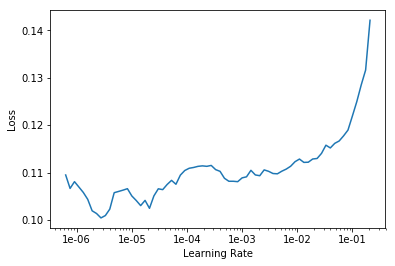

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr=1e-2/10

In [30]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.103222,0.090958,0.955383,0.919395
2,0.100736,0.086433,0.956517,0.922062
3,0.093791,0.084760,0.957686,0.924831
4,0.096328,0.084186,0.958776,0.925369
5,0.091940,0.083928,0.957083,0.925589


In [31]:
learn.save('stage-1-334')

In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-7,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.095317,0.083541,0.958238,0.926490
2,0.090458,0.083141,0.957984,0.926367


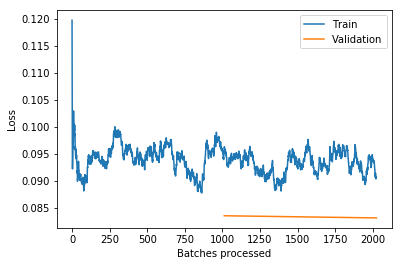

In [33]:
learn.recorder.plot_losses()

In [34]:
learn.save('stage-2-334')

Save the model for deployment.

In [35]:
learn.export()